# Published Items for the Center for Health AI

This takes a list of authors and searches for any items published this year, grabs the proper citation from manubot-cite, and creates a markdown and MS Word document.

This isn't a replacement for a proper data pipeline. Just a demo to see if the selection logic is sound.

2021/12/20 stephen.taylor@cuanschutz.edu First demo

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [17]:
import os
import logging
import manubot
import subprocess
import re
import requests
import pandas as pd
import pandoc

from datetime import date
from pprint import pprint
from typing import Tuple, Dict, List
from prefect import task, Flow, Parameter, unmapped
from prefect.executors import LocalExecutor, LocalDaskExecutor
from prefect.utilities.logging import prefect_logger

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
prefect_logger = logging

THIS_YEAR = 2021
BUILD_FOLDER = "_build"

<IPython.core.display.Javascript object>

In [19]:
# will write out to a folder
if not os.path.exists(BUILD_FOLDER):
    os.makedirs(BUILD_FOLDER)

<IPython.core.display.Javascript object>

In [3]:
# Read in the authors and their specific search terms
authors_df = pd.read_json("authors.json", orient="index")
authors_df

,author_type,search_term
Aquilante C,contributor,(Aquilante C[Author])
Barnes K,contributor,(Barnes K[Author])
Boorgula M,contributor,(Boorgula M[Author])
Brooks I,contributor,(Brooks I[Author])
Campbell M,contributor,(Campbell M[Author])
Casey Greene,pi,(Casey Greene)
Claw K,contributor,(Claw K[Author])
Cohen M,contributor,(Cohen M[Author])
Coors M,contributor,(Coors M[Author])
Crooks K,contributor,(Crooks K[Author])


<IPython.core.display.Javascript object>

In [4]:
# for testing it's nice to take a sample
# authors_df = authors_df.sample(frac=0.20)

<IPython.core.display.Javascript object>

In [5]:
# convert into a dict
author_records = authors_df.to_dict("index")
author_records

{'Aquilante C': {'author_type': 'contributor',
  'search_term': '(Aquilante C[Author])'},
 'Barnes K': {'author_type': 'contributor',
  'search_term': '(Barnes K[Author])'},
 'Boorgula M': {'author_type': 'contributor',
  'search_term': '(Boorgula M[Author])'},
 'Brooks I': {'author_type': 'contributor',
  'search_term': '(Brooks I[Author])'},
 'Campbell M': {'author_type': 'contributor',
  'search_term': '(Campbell M[Author])'},
 'Casey Greene': {'author_type': 'pi', 'search_term': '(Casey Greene)'},
 'Claw K': {'author_type': 'contributor', 'search_term': '(Claw K[Author])'},
 'Cohen M': {'author_type': 'contributor', 'search_term': '(Cohen M[Author])'},
 'Coors M': {'author_type': 'contributor', 'search_term': '(Coors M[Author])'},
 'Crooks K': {'author_type': 'contributor',
  'search_term': '(Crooks K[Author])'},
 'Fingerlin T': {'author_type': 'contributor',
  'search_term': '(Fingerlin T[Author])'},
 'Fishbein L': {'author_type': 'contributor',
  'search_term': '(Fishbein L[Autho

<IPython.core.display.Javascript object>

In [6]:
# add a date to restrict to this year
for k, v in author_records.items():
    # Restrict contributors to CU items
    if v["author_type"] == "contributor":
        v[
            "search_term"
        ] = f"({v['search_term']} AND ((\"University of Colorado\") OR (\"Colorado Center for Personalized Medicine\")))"

    # filter by date
    v[
        "search_term"
    ] = f"""("{THIS_YEAR}/01/01"[PubDate] : "3000"[PubDate]) AND {v["search_term"]})"""
author_records

{'Aquilante C': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Aquilante C[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Barnes K': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Barnes K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Boorgula M': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Boorgula M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Brooks I': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Brooks I[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))'},
 'Campbell M': {'author_type': 'contributor',
  'search_term': '("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Campbell M[Author]

<IPython.core.display.Javascript object>

In [7]:
def lookup_ncbi(term, year, api_key=None):
    # look up IDs a chunk at a time
    # NCBI asks that we use an API key... I've used mine in the past, but
    # pulled this out for source.
    ids = []

    d = date(year, 1, 1)
    delta = date.today() - d

    params = {
        "term": term,
        "format": "pmid",
        "db": "pmc",
        "tool": "CUAnschutz-Center_for_Health_AI-DEV",
        "email": "Stephen.Taylor@cuanschutz.edu",
        "format": "json",
        "retmax": 100,
        "retstart": 0,
        "reldate": delta.days,
    }

    if api_key:
        params["api_key"] = api_key

    # page through the results until there are no more ids
    while True:
        r = requests.get(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params
        )
        if r.status_code == 200:
            result = r.json()["esearchresult"]
        else:
            logging.error(f"NCBI returned a status code of {r.status_code}.")
            break

        if len(result["idlist"]) == 0:
            # no more IDs
            break
        else:
            # append the IDs to the results...
            ids = ids + result["idlist"]
            # and move the start chunk up by the size of retmax
            params["retstart"] += params["retmax"]

    return ids


# quick test
lookup_ncbi(author_records["Gregory Way"]["search_term"], THIS_YEAR)

['8525744', '8108524', '7780623']

<IPython.core.display.Javascript object>

In [8]:
# I would like to do this in parallel, but the deal with NCBI is we agree not to do that
id_dict = {}
for author, v in author_records.items():
    logging.info(f"Looking up `{author}` using {v['search_term']}")
    ids = lookup_ncbi(v["search_term"], THIS_YEAR)

    for id in ids:
        if not id_dict.get(id):
            # create an empty nested dict
            id_dict[id] = {"authors": []}
        id_dict[id]["authors"].append(author)

id_dict

INFO:root:Looking up `Aquilante C` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Aquilante C[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Barnes K` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Barnes K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Boorgula M` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Boorgula M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Brooks I` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Brooks I[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Campbell M` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Campbell M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))
INFO:root:Looking up `Casey Greene` using ("20

INFO:root:Looking up `Yang I` using ("2021/01/01"[PubDate] : "3000"[PubDate]) AND ((Yang I[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine"))))


{'8504805': {'authors': ['Aquilante C', 'Gignoux C', 'Shortt J']},
 '8047196': {'authors': ['Aquilante C']},
 '8485147': {'authors': ['Barnes K', 'Mathias R']},
 '8095117': {'authors': ['Barnes K', 'Campbell M', 'Crooks K']},
 '7875770': {'authors': ['Barnes K', 'Fingerlin T', 'Lange L', 'Mathias R']},
 '7817517': {'authors': ['Brooks I']},
 '8082311': {'authors': ['Campbell M']},
 '8613500': {'authors': ['Casey Greene', 'Melissa Haendel', 'Tellen Bennett']},
 '8562484': {'authors': ['Casey Greene']},
 '8547481': {'authors': ['Casey Greene']},
 '8525744': {'authors': ['Casey Greene', 'Gregory Way']},
 '8458035': {'authors': ['Casey Greene']},
 '8452106': {'authors': ['Casey Greene']},
 '8415599': {'authors': ['Casey Greene']},
 '8385897': {'authors': ['Casey Greene']},
 '8340473': {'authors': ['Casey Greene']},
 '8269209': {'authors': ['Casey Greene']},
 '8260469': {'authors': ['Casey Greene', 'Taylor M']},
 '8168082': {'authors': ['Casey Greene']},
 '7941644': {'authors': ['Casey Gree

<IPython.core.display.Javascript object>

How many items found?

In [9]:
len(id_dict)

149

<IPython.core.display.Javascript object>

NCBI preferred we didn't run API queries against it in parallel. No such restriction for manubot!

In [10]:
@task
def get_markdown(id: str) -> Dict[str, str]:
    # Use manubot-cite to fetch the formatted citation
    args = ["manubot", "cite", "--format=markdown", f"pmc:PMC{id}"]

    process = subprocess.run(args=args, capture_output=True, encoding="utf-8")

    process.check_returncode()

    # cite has the index number stripped out.
    return {
        "id": id,
        "cite": process.stdout[re.search("\*\*", process.stdout).start() :],
    }


@task
def create_list(id_dict):
    # break out the keys for manubot cites
    my_list = [k for k, v in id_dict.items()]
    logging.info(f"Preparing to map for {len(my_list)} items")
    return my_list


@task
def assemble_dicts(cite_list, id_dict):
    # reduce the manubot cites into the main dict and return it
    for cite_record in cite_list:
        id = cite_record["id"]
        cite = cite_record["cite"]
        id_dict[id]["cite"] = cite
    return id_dict

<IPython.core.display.Javascript object>

In [11]:
# Dask executors lets us run this is parallel
executor = LocalDaskExecutor()
with Flow("Manubot Cite Runner", executor=executor) as flow:
    ids = Parameter("ids")()

    id_list = create_list(ids)
    cite_list = get_markdown.map(id_list)
    output_dict = assemble_dicts(cite_list, id_dict)

<IPython.core.display.Javascript object>

In [12]:
# run the flow, and capture the results into manubot_results
state = flow.run(
    parameters={"ids": id_dict},
)
manubot_results = state.result[output_dict].result

[2021-12-20 15:04:56-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Manubot Cite Runner'


INFO:prefect.FlowRunner:Beginning Flow run for 'Manubot Cite Runner'


[2021-12-20 15:04:56-0700] INFO - prefect.TaskRunner | Task 'ids': Starting task run...


INFO:prefect.TaskRunner:Task 'ids': Starting task run...


[2021-12-20 15:04:56-0700] INFO - prefect.TaskRunner | Task 'ids': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'ids': Finished task run for task with final state: 'Success'


[2021-12-20 15:04:56-0700] INFO - prefect.TaskRunner | Task 'create_list': Starting task run...


INFO:prefect.TaskRunner:Task 'create_list': Starting task run...
INFO:root:Preparing to map for 149 items


[2021-12-20 15:04:56-0700] INFO - prefect.TaskRunner | Task 'create_list': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'create_list': Finished task run for task with final state: 'Success'


[2021-12-20 15:04:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown': Starting task run...


[2021-12-20 15:04:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown': Finished task run for task with final state: 'Mapped'


INFO:prefect.TaskRunner:Task 'get_markdown': Finished task run for task with final state: 'Mapped'


[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[10]': Starting task run...
[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[0]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[10]': Starting task run...


[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[1]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[0]': Starting task run...


[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[103]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[1]': Starting task run...


[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[102]': Starting task run...
[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[101]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[103]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[102]': Starting task run...


[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[100]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[101]': Starting task run...


[2021-12-20 15:04:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[104]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[100]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[104]': Starting task run...


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[1]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[1]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[101]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[101]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[103]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[103]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[100]': Finished task run for task with final state: 'Success'
[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[10]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[100]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[102]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[10]': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'get_markdown[102]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[0]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[0]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[104]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[104]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[105]': Starting task run...
[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[106]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[105]': Starting task run...


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[107]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[106]': Starting task run...


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[108]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[107]': Starting task run...


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[109]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[108]': Starting task run...


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[11]': Starting task run...
[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[110]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[109]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[11]': Starting task run...


[2021-12-20 15:05:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[111]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[110]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[111]': Starting task run...


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[111]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[111]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[110]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[110]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[112]': Starting task run...
[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[113]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[112]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[113]': Starting task run...


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[109]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[109]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[106]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[106]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[108]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[108]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[105]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[105]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[11]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[11]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[107]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[107]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[114]': Starting task run...
[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[115]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[114]': Starting task run...


[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[116]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[115]': Starting task run...


[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[117]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[116]': Starting task run...


[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[118]': Starting task run...
[2021-12-20 15:05:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[119]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[117]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[118]': Starting task run...
INFO:prefect.TaskRunner:Task 'get_markdown[119]': Starting task run...


[2021-12-20 15:05:38-0700] INFO - prefect.TaskRunner | Task 'get_markdown[112]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[112]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:38-0700] INFO - prefect.TaskRunner | Task 'get_markdown[113]': Finished task run for task with final state: 'Success'
[2021-12-20 15:05:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[12]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[113]': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'get_markdown[12]': Starting task run...


[2021-12-20 15:05:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[120]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[120]': Starting task run...


[2021-12-20 15:05:41-0700] INFO - prefect.TaskRunner | Task 'get_markdown[114]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[114]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:41-0700] INFO - prefect.TaskRunner | Task 'get_markdown[121]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[121]': Starting task run...


[2021-12-20 15:05:42-0700] INFO - prefect.TaskRunner | Task 'get_markdown[116]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[116]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:42-0700] INFO - prefect.TaskRunner | Task 'get_markdown[118]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[118]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[117]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[117]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[115]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[115]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[119]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[119]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[122]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[122]': Starting task run...


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[123]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[123]': Starting task run...


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[124]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[124]': Starting task run...


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[125]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[125]': Starting task run...


[2021-12-20 15:05:43-0700] INFO - prefect.TaskRunner | Task 'get_markdown[126]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[126]': Starting task run...


[2021-12-20 15:05:49-0700] INFO - prefect.TaskRunner | Task 'get_markdown[120]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[120]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:49-0700] INFO - prefect.TaskRunner | Task 'get_markdown[127]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[127]': Starting task run...


[2021-12-20 15:05:49-0700] INFO - prefect.TaskRunner | Task 'get_markdown[12]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[12]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:49-0700] INFO - prefect.TaskRunner | Task 'get_markdown[128]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[128]': Starting task run...


[2021-12-20 15:05:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[121]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[121]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[129]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[129]': Starting task run...


[2021-12-20 15:05:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[123]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[123]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[13]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[13]': Starting task run...


[2021-12-20 15:05:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[124]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[124]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[130]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[130]': Starting task run...


[2021-12-20 15:05:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[126]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[126]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[131]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[131]': Starting task run...


[2021-12-20 15:05:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[125]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[125]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[132]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[132]': Starting task run...


[2021-12-20 15:05:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[122]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[122]': Finished task run for task with final state: 'Success'


[2021-12-20 15:05:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[133]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[133]': Starting task run...


[2021-12-20 15:06:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[127]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[127]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[134]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[134]': Starting task run...


[2021-12-20 15:06:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[128]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[128]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[135]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[135]': Starting task run...


[2021-12-20 15:06:02-0700] INFO - prefect.TaskRunner | Task 'get_markdown[129]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[129]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:02-0700] INFO - prefect.TaskRunner | Task 'get_markdown[136]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[136]': Starting task run...


[2021-12-20 15:06:07-0700] INFO - prefect.TaskRunner | Task 'get_markdown[13]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[13]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:07-0700] INFO - prefect.TaskRunner | Task 'get_markdown[137]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[137]': Starting task run...


[2021-12-20 15:06:09-0700] INFO - prefect.TaskRunner | Task 'get_markdown[130]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[130]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:09-0700] INFO - prefect.TaskRunner | Task 'get_markdown[138]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[138]': Starting task run...


[2021-12-20 15:06:10-0700] INFO - prefect.TaskRunner | Task 'get_markdown[131]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[131]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:10-0700] INFO - prefect.TaskRunner | Task 'get_markdown[139]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[139]': Starting task run...


[2021-12-20 15:06:10-0700] INFO - prefect.TaskRunner | Task 'get_markdown[133]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[133]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:10-0700] INFO - prefect.TaskRunner | Task 'get_markdown[14]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[14]': Starting task run...


[2021-12-20 15:06:11-0700] INFO - prefect.TaskRunner | Task 'get_markdown[132]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[132]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:11-0700] INFO - prefect.TaskRunner | Task 'get_markdown[140]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[140]': Starting task run...


[2021-12-20 15:06:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[134]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[134]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[141]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[141]': Starting task run...


[2021-12-20 15:06:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[135]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[135]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[142]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[142]': Starting task run...


[2021-12-20 15:06:14-0700] INFO - prefect.TaskRunner | Task 'get_markdown[136]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[136]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:14-0700] INFO - prefect.TaskRunner | Task 'get_markdown[143]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[143]': Starting task run...


[2021-12-20 15:06:20-0700] INFO - prefect.TaskRunner | Task 'get_markdown[137]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[137]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:20-0700] INFO - prefect.TaskRunner | Task 'get_markdown[144]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[144]': Starting task run...


[2021-12-20 15:06:22-0700] INFO - prefect.TaskRunner | Task 'get_markdown[138]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[138]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:22-0700] INFO - prefect.TaskRunner | Task 'get_markdown[145]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[145]': Starting task run...


[2021-12-20 15:06:24-0700] INFO - prefect.TaskRunner | Task 'get_markdown[139]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[139]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:24-0700] INFO - prefect.TaskRunner | Task 'get_markdown[146]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[146]': Starting task run...


[2021-12-20 15:06:24-0700] INFO - prefect.TaskRunner | Task 'get_markdown[140]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[140]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:24-0700] INFO - prefect.TaskRunner | Task 'get_markdown[147]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[147]': Starting task run...


[2021-12-20 15:06:25-0700] INFO - prefect.TaskRunner | Task 'get_markdown[14]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[14]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:25-0700] INFO - prefect.TaskRunner | Task 'get_markdown[148]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[148]': Starting task run...


[2021-12-20 15:06:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[141]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[141]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[15]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[15]': Starting task run...


[2021-12-20 15:06:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[142]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[142]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[16]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[16]': Starting task run...


[2021-12-20 15:06:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[143]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[143]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[17]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[17]': Starting task run...


[2021-12-20 15:06:31-0700] INFO - prefect.TaskRunner | Task 'get_markdown[144]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[144]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:31-0700] INFO - prefect.TaskRunner | Task 'get_markdown[18]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[18]': Starting task run...


[2021-12-20 15:06:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[145]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[145]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[19]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[19]': Starting task run...


[2021-12-20 15:06:36-0700] INFO - prefect.TaskRunner | Task 'get_markdown[146]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[146]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:36-0700] INFO - prefect.TaskRunner | Task 'get_markdown[2]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[2]': Starting task run...


[2021-12-20 15:06:36-0700] INFO - prefect.TaskRunner | Task 'get_markdown[147]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[147]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:36-0700] INFO - prefect.TaskRunner | Task 'get_markdown[20]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[20]': Starting task run...


[2021-12-20 15:06:38-0700] INFO - prefect.TaskRunner | Task 'get_markdown[148]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[148]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:38-0700] INFO - prefect.TaskRunner | Task 'get_markdown[21]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[21]': Starting task run...


[2021-12-20 15:06:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[15]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[15]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[22]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[22]': Starting task run...


[2021-12-20 15:06:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[16]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[16]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:40-0700] INFO - prefect.TaskRunner | Task 'get_markdown[23]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[23]': Starting task run...


[2021-12-20 15:06:40-0700] INFO - prefect.TaskRunner | Task 'get_markdown[17]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[17]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:40-0700] INFO - prefect.TaskRunner | Task 'get_markdown[24]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[24]': Starting task run...


[2021-12-20 15:06:44-0700] INFO - prefect.TaskRunner | Task 'get_markdown[18]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[18]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:44-0700] INFO - prefect.TaskRunner | Task 'get_markdown[25]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[25]': Starting task run...


[2021-12-20 15:06:45-0700] INFO - prefect.TaskRunner | Task 'get_markdown[19]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[19]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:45-0700] INFO - prefect.TaskRunner | Task 'get_markdown[26]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[26]': Starting task run...


[2021-12-20 15:06:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[20]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[20]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[27]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[27]': Starting task run...


[2021-12-20 15:06:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[2]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[2]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[28]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[28]': Starting task run...


[2021-12-20 15:06:51-0700] INFO - prefect.TaskRunner | Task 'get_markdown[21]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[21]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:51-0700] INFO - prefect.TaskRunner | Task 'get_markdown[29]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[29]': Starting task run...


[2021-12-20 15:06:52-0700] INFO - prefect.TaskRunner | Task 'get_markdown[22]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[22]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:52-0700] INFO - prefect.TaskRunner | Task 'get_markdown[3]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[3]': Starting task run...


[2021-12-20 15:06:53-0700] INFO - prefect.TaskRunner | Task 'get_markdown[23]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[23]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:53-0700] INFO - prefect.TaskRunner | Task 'get_markdown[30]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[30]': Starting task run...


[2021-12-20 15:06:53-0700] INFO - prefect.TaskRunner | Task 'get_markdown[24]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[24]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:53-0700] INFO - prefect.TaskRunner | Task 'get_markdown[31]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[31]': Starting task run...


[2021-12-20 15:06:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[25]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[25]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:57-0700] INFO - prefect.TaskRunner | Task 'get_markdown[32]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[32]': Starting task run...


[2021-12-20 15:06:58-0700] INFO - prefect.TaskRunner | Task 'get_markdown[26]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[26]': Finished task run for task with final state: 'Success'


[2021-12-20 15:06:58-0700] INFO - prefect.TaskRunner | Task 'get_markdown[33]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[33]': Starting task run...


[2021-12-20 15:07:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[27]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[27]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[28]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[28]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[34]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[34]': Starting task run...


[2021-12-20 15:07:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[35]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[35]': Starting task run...


[2021-12-20 15:07:04-0700] INFO - prefect.TaskRunner | Task 'get_markdown[29]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[29]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:04-0700] INFO - prefect.TaskRunner | Task 'get_markdown[36]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[36]': Starting task run...


[2021-12-20 15:07:05-0700] INFO - prefect.TaskRunner | Task 'get_markdown[3]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[3]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:05-0700] INFO - prefect.TaskRunner | Task 'get_markdown[37]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[37]': Starting task run...


[2021-12-20 15:07:06-0700] INFO - prefect.TaskRunner | Task 'get_markdown[30]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[30]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:06-0700] INFO - prefect.TaskRunner | Task 'get_markdown[38]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[38]': Starting task run...


[2021-12-20 15:07:06-0700] INFO - prefect.TaskRunner | Task 'get_markdown[31]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[31]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:06-0700] INFO - prefect.TaskRunner | Task 'get_markdown[39]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[39]': Starting task run...


[2021-12-20 15:07:08-0700] INFO - prefect.TaskRunner | Task 'get_markdown[32]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[32]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:08-0700] INFO - prefect.TaskRunner | Task 'get_markdown[4]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[4]': Starting task run...


[2021-12-20 15:07:11-0700] INFO - prefect.TaskRunner | Task 'get_markdown[33]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[33]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:11-0700] INFO - prefect.TaskRunner | Task 'get_markdown[40]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[40]': Starting task run...


[2021-12-20 15:07:17-0700] INFO - prefect.TaskRunner | Task 'get_markdown[35]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[35]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:17-0700] INFO - prefect.TaskRunner | Task 'get_markdown[41]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[41]': Starting task run...


[2021-12-20 15:07:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[34]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[34]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[42]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[42]': Starting task run...


[2021-12-20 15:07:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[37]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[37]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[43]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[43]': Starting task run...


[2021-12-20 15:07:19-0700] INFO - prefect.TaskRunner | Task 'get_markdown[38]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[38]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:19-0700] INFO - prefect.TaskRunner | Task 'get_markdown[44]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[44]': Starting task run...


[2021-12-20 15:07:19-0700] INFO - prefect.TaskRunner | Task 'get_markdown[39]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[39]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:19-0700] INFO - prefect.TaskRunner | Task 'get_markdown[45]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[45]': Starting task run...


[2021-12-20 15:07:20-0700] INFO - prefect.TaskRunner | Task 'get_markdown[4]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[4]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:20-0700] INFO - prefect.TaskRunner | Task 'get_markdown[46]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[46]': Starting task run...


[2021-12-20 15:07:21-0700] INFO - prefect.TaskRunner | Task 'get_markdown[36]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[36]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:21-0700] INFO - prefect.TaskRunner | Task 'get_markdown[47]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[47]': Starting task run...


[2021-12-20 15:07:21-0700] INFO - prefect.TaskRunner | Task 'get_markdown[40]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[40]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:21-0700] INFO - prefect.TaskRunner | Task 'get_markdown[48]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[48]': Starting task run...


[2021-12-20 15:07:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[41]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[41]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[49]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[49]': Starting task run...


[2021-12-20 15:07:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[42]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[42]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[5]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[5]': Starting task run...


[2021-12-20 15:07:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[43]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[43]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[50]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[50]': Starting task run...


[2021-12-20 15:07:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[45]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[45]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[51]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[51]': Starting task run...


[2021-12-20 15:07:34-0700] INFO - prefect.TaskRunner | Task 'get_markdown[44]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[44]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:34-0700] INFO - prefect.TaskRunner | Task 'get_markdown[52]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[52]': Starting task run...


[2021-12-20 15:07:34-0700] INFO - prefect.TaskRunner | Task 'get_markdown[48]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[48]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:34-0700] INFO - prefect.TaskRunner | Task 'get_markdown[53]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[53]': Starting task run...


[2021-12-20 15:07:35-0700] INFO - prefect.TaskRunner | Task 'get_markdown[46]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[46]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:35-0700] INFO - prefect.TaskRunner | Task 'get_markdown[54]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[54]': Starting task run...


[2021-12-20 15:07:35-0700] INFO - prefect.TaskRunner | Task 'get_markdown[47]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[47]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:35-0700] INFO - prefect.TaskRunner | Task 'get_markdown[55]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[55]': Starting task run...


[2021-12-20 15:07:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[5]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[5]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[56]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[56]': Starting task run...


[2021-12-20 15:07:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[49]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[49]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:39-0700] INFO - prefect.TaskRunner | Task 'get_markdown[57]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[57]': Starting task run...


[2021-12-20 15:07:45-0700] INFO - prefect.TaskRunner | Task 'get_markdown[53]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[53]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:45-0700] INFO - prefect.TaskRunner | Task 'get_markdown[58]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[58]': Starting task run...


[2021-12-20 15:07:47-0700] INFO - prefect.TaskRunner | Task 'get_markdown[50]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[50]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:47-0700] INFO - prefect.TaskRunner | Task 'get_markdown[59]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[59]': Starting task run...


[2021-12-20 15:07:48-0700] INFO - prefect.TaskRunner | Task 'get_markdown[52]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[52]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:48-0700] INFO - prefect.TaskRunner | Task 'get_markdown[6]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[6]': Starting task run...


[2021-12-20 15:07:48-0700] INFO - prefect.TaskRunner | Task 'get_markdown[51]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[51]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:48-0700] INFO - prefect.TaskRunner | Task 'get_markdown[60]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[60]': Starting task run...


[2021-12-20 15:07:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[54]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[54]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[61]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[61]': Starting task run...


[2021-12-20 15:07:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[56]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[56]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[62]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[62]': Starting task run...


[2021-12-20 15:07:51-0700] INFO - prefect.TaskRunner | Task 'get_markdown[55]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[55]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:51-0700] INFO - prefect.TaskRunner | Task 'get_markdown[63]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[63]': Starting task run...


[2021-12-20 15:07:53-0700] INFO - prefect.TaskRunner | Task 'get_markdown[57]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[57]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:53-0700] INFO - prefect.TaskRunner | Task 'get_markdown[64]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[64]': Starting task run...


[2021-12-20 15:07:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[58]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[58]': Finished task run for task with final state: 'Success'


[2021-12-20 15:07:56-0700] INFO - prefect.TaskRunner | Task 'get_markdown[65]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[65]': Starting task run...


[2021-12-20 15:08:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[59]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[59]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[66]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[66]': Starting task run...


[2021-12-20 15:08:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[6]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[6]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[67]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[67]': Starting task run...


[2021-12-20 15:08:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[60]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[60]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[68]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[68]': Starting task run...


[2021-12-20 15:08:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[61]': Finished task run for task with final state: 'Success'
[2021-12-20 15:08:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[63]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[61]': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'get_markdown[63]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[69]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[69]': Starting task run...


[2021-12-20 15:08:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[7]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[7]': Starting task run...


[2021-12-20 15:08:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[62]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[62]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:03-0700] INFO - prefect.TaskRunner | Task 'get_markdown[70]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[70]': Starting task run...


[2021-12-20 15:08:04-0700] INFO - prefect.TaskRunner | Task 'get_markdown[64]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[64]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:04-0700] INFO - prefect.TaskRunner | Task 'get_markdown[71]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[71]': Starting task run...


[2021-12-20 15:08:07-0700] INFO - prefect.TaskRunner | Task 'get_markdown[65]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[65]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:07-0700] INFO - prefect.TaskRunner | Task 'get_markdown[72]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[72]': Starting task run...


[2021-12-20 15:08:11-0700] INFO - prefect.TaskRunner | Task 'get_markdown[66]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[66]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:11-0700] INFO - prefect.TaskRunner | Task 'get_markdown[73]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[73]': Starting task run...


[2021-12-20 15:08:13-0700] INFO - prefect.TaskRunner | Task 'get_markdown[67]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[67]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:14-0700] INFO - prefect.TaskRunner | Task 'get_markdown[74]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[74]': Starting task run...


[2021-12-20 15:08:14-0700] INFO - prefect.TaskRunner | Task 'get_markdown[68]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[68]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:14-0700] INFO - prefect.TaskRunner | Task 'get_markdown[75]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[75]': Starting task run...


[2021-12-20 15:08:16-0700] INFO - prefect.TaskRunner | Task 'get_markdown[7]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[7]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:16-0700] INFO - prefect.TaskRunner | Task 'get_markdown[76]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[76]': Starting task run...


[2021-12-20 15:08:17-0700] INFO - prefect.TaskRunner | Task 'get_markdown[69]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[69]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:17-0700] INFO - prefect.TaskRunner | Task 'get_markdown[77]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[77]': Starting task run...


[2021-12-20 15:08:17-0700] INFO - prefect.TaskRunner | Task 'get_markdown[71]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[71]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[78]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[78]': Starting task run...


[2021-12-20 15:08:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[70]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[70]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:18-0700] INFO - prefect.TaskRunner | Task 'get_markdown[79]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[79]': Starting task run...


[2021-12-20 15:08:19-0700] INFO - prefect.TaskRunner | Task 'get_markdown[72]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[72]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:19-0700] INFO - prefect.TaskRunner | Task 'get_markdown[8]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[8]': Starting task run...


[2021-12-20 15:08:22-0700] INFO - prefect.TaskRunner | Task 'get_markdown[73]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[73]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:22-0700] INFO - prefect.TaskRunner | Task 'get_markdown[80]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[80]': Starting task run...


[2021-12-20 15:08:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[74]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[74]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:26-0700] INFO - prefect.TaskRunner | Task 'get_markdown[81]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[81]': Starting task run...


[2021-12-20 15:08:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[75]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[75]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:27-0700] INFO - prefect.TaskRunner | Task 'get_markdown[82]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[82]': Starting task run...


[2021-12-20 15:08:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[76]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[76]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:28-0700] INFO - prefect.TaskRunner | Task 'get_markdown[83]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[83]': Starting task run...


[2021-12-20 15:08:30-0700] INFO - prefect.TaskRunner | Task 'get_markdown[77]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[77]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:30-0700] INFO - prefect.TaskRunner | Task 'get_markdown[84]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[84]': Starting task run...


[2021-12-20 15:08:31-0700] INFO - prefect.TaskRunner | Task 'get_markdown[78]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[78]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[85]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[85]': Starting task run...


[2021-12-20 15:08:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[79]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[79]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[86]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[86]': Starting task run...


[2021-12-20 15:08:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[8]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[8]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:32-0700] INFO - prefect.TaskRunner | Task 'get_markdown[87]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[87]': Starting task run...


[2021-12-20 15:08:34-0700] INFO - prefect.TaskRunner | Task 'get_markdown[80]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[80]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:34-0700] INFO - prefect.TaskRunner | Task 'get_markdown[88]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[88]': Starting task run...


[2021-12-20 15:08:38-0700] INFO - prefect.TaskRunner | Task 'get_markdown[81]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[81]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:38-0700] INFO - prefect.TaskRunner | Task 'get_markdown[89]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[89]': Starting task run...


[2021-12-20 15:08:40-0700] INFO - prefect.TaskRunner | Task 'get_markdown[82]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[82]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:40-0700] INFO - prefect.TaskRunner | Task 'get_markdown[9]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[9]': Starting task run...


[2021-12-20 15:08:41-0700] INFO - prefect.TaskRunner | Task 'get_markdown[83]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[83]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:41-0700] INFO - prefect.TaskRunner | Task 'get_markdown[90]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[90]': Starting task run...


[2021-12-20 15:08:42-0700] INFO - prefect.TaskRunner | Task 'get_markdown[84]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[84]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:42-0700] INFO - prefect.TaskRunner | Task 'get_markdown[91]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[91]': Starting task run...


[2021-12-20 15:08:46-0700] INFO - prefect.TaskRunner | Task 'get_markdown[85]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[85]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:46-0700] INFO - prefect.TaskRunner | Task 'get_markdown[92]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[92]': Starting task run...


[2021-12-20 15:08:46-0700] INFO - prefect.TaskRunner | Task 'get_markdown[86]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[86]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:46-0700] INFO - prefect.TaskRunner | Task 'get_markdown[93]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[93]': Starting task run...


[2021-12-20 15:08:46-0700] INFO - prefect.TaskRunner | Task 'get_markdown[87]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[87]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:46-0700] INFO - prefect.TaskRunner | Task 'get_markdown[94]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[94]': Starting task run...


[2021-12-20 15:08:47-0700] INFO - prefect.TaskRunner | Task 'get_markdown[88]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[88]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:47-0700] INFO - prefect.TaskRunner | Task 'get_markdown[95]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[95]': Starting task run...


[2021-12-20 15:08:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[89]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[89]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:50-0700] INFO - prefect.TaskRunner | Task 'get_markdown[96]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[96]': Starting task run...


[2021-12-20 15:08:52-0700] INFO - prefect.TaskRunner | Task 'get_markdown[9]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[9]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:52-0700] INFO - prefect.TaskRunner | Task 'get_markdown[97]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[97]': Starting task run...


[2021-12-20 15:08:54-0700] INFO - prefect.TaskRunner | Task 'get_markdown[90]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[90]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:54-0700] INFO - prefect.TaskRunner | Task 'get_markdown[98]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[98]': Starting task run...


[2021-12-20 15:08:54-0700] INFO - prefect.TaskRunner | Task 'get_markdown[91]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[91]': Finished task run for task with final state: 'Success'


[2021-12-20 15:08:55-0700] INFO - prefect.TaskRunner | Task 'get_markdown[99]': Starting task run...


INFO:prefect.TaskRunner:Task 'get_markdown[99]': Starting task run...


[2021-12-20 15:08:59-0700] INFO - prefect.TaskRunner | Task 'get_markdown[93]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[93]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:00-0700] INFO - prefect.TaskRunner | Task 'get_markdown[92]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[92]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:00-0700] INFO - prefect.TaskRunner | Task 'get_markdown[94]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[94]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:00-0700] INFO - prefect.TaskRunner | Task 'get_markdown[95]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[95]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:01-0700] INFO - prefect.TaskRunner | Task 'get_markdown[96]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[96]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:02-0700] INFO - prefect.TaskRunner | Task 'get_markdown[97]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[97]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:02-0700] INFO - prefect.TaskRunner | Task 'get_markdown[98]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[98]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:02-0700] INFO - prefect.TaskRunner | Task 'get_markdown[99]': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'get_markdown[99]': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:02-0700] INFO - prefect.TaskRunner | Task 'assemble_dicts': Starting task run...


INFO:prefect.TaskRunner:Task 'assemble_dicts': Starting task run...


[2021-12-20 15:09:02-0700] INFO - prefect.TaskRunner | Task 'assemble_dicts': Finished task run for task with final state: 'Success'


INFO:prefect.TaskRunner:Task 'assemble_dicts': Finished task run for task with final state: 'Success'


[2021-12-20 15:09:02-0700] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


INFO:prefect.FlowRunner:Flow run SUCCESS: all reference tasks succeeded


<IPython.core.display.Javascript object>

In [13]:
# Sorting is straight-forward with Pandas
df = pd.DataFrame.from_dict(manubot_results, orient="index")
df.sort_values(by="cite", inplace=True)
# adding a number for each site as asked.
df["index_num"] = range(1, len(df.index) + 1)
df["numbered_cite"] = df.apply(lambda x: f"{x.index_num}. {x.cite}", axis=1)
df

,authors,cite,index_num,numbered_cite
8399445,"[Johnson RK, Kechris K, Yang I]",**A Mediation Approach to Discovering Causal R...,1,1. **A Mediation Approach to Discovering Causa...
7859930,[Kechris K],**A Practical Guide to Metabolomics Software D...,2,2. **A Practical Guide to Metabolomics Softwar...
8485147,"[Barnes K, Mathias R]",**A System for Phenotype Harmonization in the ...,3,3. **A System for Phenotype Harmonization in t...
8525744,"[Casey Greene, Gregory Way]",**A field guide to cultivating computational b...,4,4. **A field guide to cultivating computationa...
8492620,[Ghosh D],**A novel approach to understanding Parkinsoni...,5,5. **A novel approach to understanding Parkins...
...,...,...,...,...
8206199,"[Lange L, Mathias R]",**Whole-genome sequencing association analysis...,145,145. **Whole-genome sequencing association ana...
8095117,"[Barnes K, Campbell M, Crooks K]",**Zika Virus Congenital Syndrome and MTOR gene...,146,146. **Zika Virus Congenital Syndrome and MTOR...
7822150,[Taylor M],**cAMP-Independent Activation of the Unfolded ...,147,147. **cAMP-Independent Activation of the Unfo...
8415599,[Casey Greene],**miQC: An adaptive probabilistic framework fo...,148,148. **miQC: An adaptive probabilistic framewo...


<IPython.core.display.Javascript object>

In [14]:
# count the items and add to the original authors dataframe
author_paper_count = {}
for k, v in id_dict.items():
    for author in v["authors"]:
        if not author_paper_count.get(author):
            author_paper_count[author] = 0
        author_paper_count[author] += 1

authors_df["item_count"] = pd.Series(author_paper_count)
authors_df

,author_type,search_term,item_count
Aquilante C,contributor,(Aquilante C[Author]),2.0
Barnes K,contributor,(Barnes K[Author]),3.0
Boorgula M,contributor,(Boorgula M[Author]),NaN
Brooks I,contributor,(Brooks I[Author]),1.0
Campbell M,contributor,(Campbell M[Author]),2.0
Casey Greene,pi,(Casey Greene),16.0
Claw K,contributor,(Claw K[Author]),3.0
Cohen M,contributor,(Cohen M[Author]),4.0
Coors M,contributor,(Coors M[Author]),3.0
Crooks K,contributor,(Crooks K[Author]),1.0


<IPython.core.display.Javascript object>

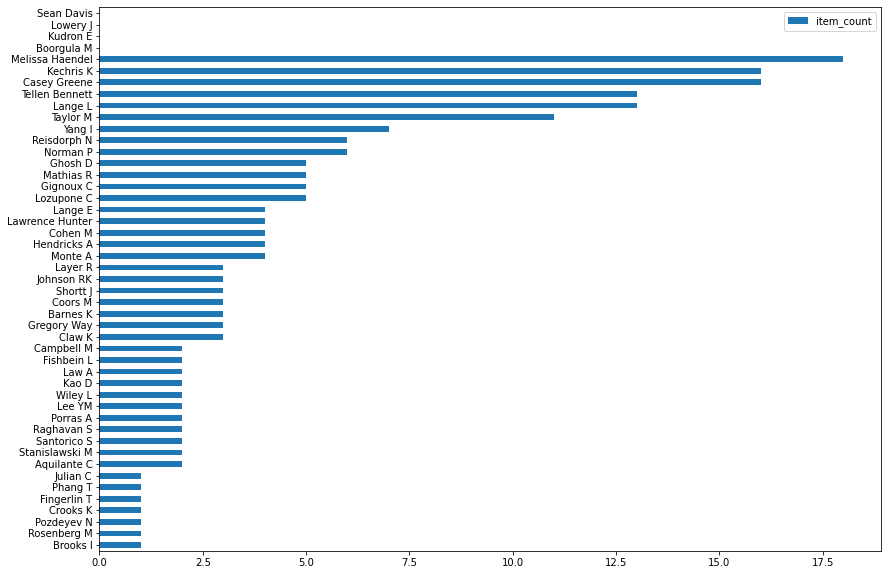

<IPython.core.display.Javascript object>

In [24]:
# I wanted to _see_ what the data looked like
ax = authors_df.sort_values(by="item_count").plot.barh(figsize=(14, 10))
fig = ax.get_figure()
fig.savefig(os.path.join(BUILD_FOLDER, "author_items.png"))

Finally output the content to a markdown file, then convert to MS Word

In [25]:
# dump to a file to inspect
df.to_json(os.path.join(BUILD_FOLDER, "cites.json"), orient="index")

<IPython.core.display.Javascript object>

In [31]:
with open(os.path.join(BUILD_FOLDER, "cites.md"), "w", encoding="utf-8") as f:
    f.write(f"# Center for Health AI, Published Items {THIS_YEAR}\n\n")

    f.write(f"## Author Item Counts\n\n")
    f.write(f"![](_build/author_items.png)\n\n")

    f.write(f"## Published Items Citations\n\n")
    for index, row in df.iterrows():
        f.write(row["numbered_cite"])
        f.write("\n")

<IPython.core.display.Javascript object>

In [32]:
# Convert the markdown to docx
doc = pandoc.read(file=os.path.join(BUILD_FOLDER, "cites.md"), format="markdown")
with open(os.path.join(BUILD_FOLDER, "cites.docx"), "wb") as f:
    _ = f.write(pandoc.write(doc, format="docx"))

<IPython.core.display.Javascript object>